In [140]:
from d2l import mxnet as d2l
from mxnet import gluon, autograd, np, npx
from mxnet.gluon import nn

npx.set_np()

In [141]:
# Define the weight, bias and super parameters
num_inputs, num_hidden1, num_hidden2, num_outputs = 28 * 28, 256, 256, 10
learning_rate = 0.5
batch_size = 256
num_epochs = 10
dropout_p1, dropout_p2 = 0.2, 0.5

W1 = np.random.normal(scale = 0.01, size = (num_inputs, num_hidden1))
b1 = np.zeros(shape = (1, num_hidden1))

W2 = np.random.normal(scale = 0.01, size = (num_hidden1, num_hidden2))
b2 = np.zeros(shape = (1, num_hidden2))

W3 = np.random.normal(scale = 0.01, size = (num_hidden2, num_outputs))
b3 = np.zeros(shape = (1, num_outputs))

params = [W1, b1, W2, b2, W3, b3]
weight = [W1, W2, W3]
bias = [b1, b2, b3]

for param in params:
    param.attach_grad()

In [142]:
# Define loss cross entropy
# def loss(y_hat, y):
#     y_hat = npx.softmax(y_hat, axis = 1)
#     return - np.log(y_hat[range(len(y_hat)), y])
def loss(y_hat, y):
    y_hat = npx.softmax(y_hat, axis = 1)
    return -np.log(y_hat[range(y_hat.shape[0]), y])

def optimizer(weight, bias, learning_rate, batch_size, wd, wd_mult = 1):
    # for param in params:
    #     param[:] = param - learning_rate / batch_size * param.grad
    for W in weight:
        W[:] = W - learning_rate / batch_size * W.grad - learning_rate * wd * W
    for b in bias:
        b[:] = b - learning_rate / batch_size * b.grad - learning_rate * wd_mult * wd * b 

# Define trainer function
def epoch_trainer(net, train_iter, wd = 0):
    # 3 metric: train_loss, train_accuracy, total_examples
    metric = d2l.Accumulator(3)

    for X, y in train_iter:
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        optimizer(weight, bias, learning_rate, batch_size, wd)
        metric.add(l.sum(), d2l.accuracy(y_hat, y), y.size)
    return metric[0] / metric[2], metric[1] / metric[2]

def train(net, train_iter, test_iter, wd = 0):
    anim = d2l.Animator(
        xlabel="epochs", legend = ["train_loss", "train_accuracy", "test_accuracy"],
        xlim=[1, num_epochs], ylim = [0, 1]
    )
    train_data = []
    for epoch in range(num_epochs):
        train_loss, train_acc = epoch_trainer(net, train_iter, wd)
        for X, y in test_iter:
            test_acc = d2l.accuracy(net(X), y) / len(y)
            break
        # print(train_loss, train_acc, test_acc)
        train_data.append((train_loss, train_acc, test_acc))
        anim.add([epoch + 1] * 3, [train_loss, train_acc, test_acc])
    print(train_data[-1])
    return train_data

In [143]:
# Define the dropout layer
def dropout(X, percentage):
    if percentage == 0:
        return X
    if percentage == 1:
        return np.zeros_like(X)
    
    choose_index = np.random.uniform(0, 1, size = X.shape) > percentage
    return choose_index.astype("float32") * X / (1 - percentage)

X = np.arange(0, 16).reshape((2, 8))
print(X)
print(dropout(X, 0.5))
print(dropout(X, 0))
print(dropout(X, 1))

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
[[ 0.  0.  4.  0.  8.  0. 12. 14.]
 [ 0.  0.  0. 22. 24.  0. 28.  0.]]
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


(0.34162573738098145, 0.8755666666666667, 0.875)


[(1.105222026570638, 0.5720166666666666, 0.80859375),
 (0.5737015488942464, 0.7873833333333333, 0.83984375),
 (0.48375629806518555, 0.8233166666666667, 0.84375),
 (0.44190949020385745, 0.8372833333333334, 0.8515625),
 (0.41764475015004476, 0.8478666666666667, 0.89453125),
 (0.3950264033317566, 0.8558166666666667, 0.86328125),
 (0.3778636468251546, 0.8605, 0.87109375),
 (0.3639815599123637, 0.86625, 0.859375),
 (0.3523061587651571, 0.8705833333333334, 0.87890625),
 (0.34162573738098145, 0.8755666666666667, 0.875)]

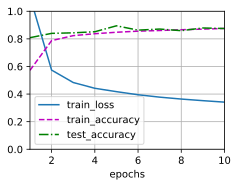

In [144]:
# Define the network
def net(X):
    X = X.reshape(-1, num_inputs)
    H1 = npx.relu(np.dot(X, W1) + b1)
    
    if (autograd.is_training()):
        H1 = dropout(H1, dropout_p1)

    H2 = npx.relu(np.dot(H1, W2) + b2)
    
    if (autograd.is_training()):
        H2 = dropout(H2, dropout_p2)

    return np.dot(H2, W3) + b3

# Get data iterators from Fashion-MNIST
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

train(net, train_iter, test_iter)

(0.41277684675852455, 0.8496333333333334, 0.87109375)


[(1.274017200088501, 0.50055, 0.796875),
 (0.6242887998580933, 0.76705, 0.8359375),
 (0.5299517333984375, 0.8072833333333334, 0.84375),
 (0.4945532729466756, 0.8186166666666667, 0.875),
 (0.4646145846048991, 0.8308833333333333, 0.87109375),
 (0.4594650157292684, 0.8336666666666667, 0.859375),
 (0.43566755873362223, 0.8409666666666666, 0.8671875),
 (0.4289919567108154, 0.8440833333333333, 0.8203125),
 (0.4228528205235799, 0.8469, 0.875),
 (0.41277684675852455, 0.8496333333333334, 0.87109375)]

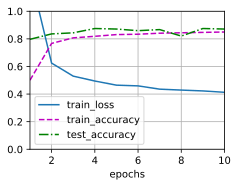

In [145]:
# Train the model with weight decay and dropout
W1 = np.random.normal(scale = 0.01, size = (num_inputs, num_hidden1))
b1 = np.zeros(shape = (1, num_hidden1))

W2 = np.random.normal(scale = 0.01, size = (num_hidden1, num_hidden2))
b2 = np.zeros(shape = (1, num_hidden2))

W3 = np.random.normal(scale = 0.01, size = (num_hidden2, num_outputs))
b3 = np.zeros(shape = (1, num_outputs))

params = [W1, b1, W2, b2, W3, b3]
weight = [W1, W2, W3]
bias = [b1, b2, b3]

for param in params:
    param.attach_grad()

train(net, train_iter, test_iter, wd = 0.001)


#### Kết luận
- Có thể sử dụng chung dropout và suy giảm trong số l2. Dropout giúp cho các nơ ron bớt phụ thuộc vào các nơ ron trước đó, còn suy giảm trọng số l2 giúp giảm độ phức tạp của mô hình.
#### Định nghĩa bộ đào tạo, bộ xác thực và bộ kiểm tra
- Bộ đào tạo (training set): Một tập hợp các dữ liệu được sử dụng để học. Giúp điều chỉnh tham số trong MLP phân loại.
- Bộ xác thực (validation set): Tập hợp các ví dụ được sử dụng để điều chỉnh các siêu tham số của bộ phân loại. -> bộ dữ liệu ta sử dụng từ đầu đến giờ thực chất là bộ xác thực chứ không phải bộ kiểm tra.
- Bộ kiểm tra (test set): Một tập hợp các ví dụ chỉ được sử dụng để đánh giá hiệu suất của mô hình. Trong trường hợp MLP, ta sử dụng bộ kiểm tra để ước tính tỷ lệ lỗi sau khi đã chọn mô hình cuối cùng. Sau khi đánh giá mô hình cuối cùng trên bộ kiểm tra thì KHÔNG ĐƯỢC điều chỉnh mô hình thêm nữa.

#### Lý do không sử dụng dropout trong việc kiểm tra dữ liệu và xác thực:
- Định nghĩa dropout: Dropout là một quá trình ngẫu nhiên vô hiệu hóa các neuron trong một lớp với xác suất p. Điều này sẽ khiến cho một số neuron cảm thấy "sai" về đầu ra của chúng trong mỗi lần lặp, làm chúng ít phụ thuộc hơn vào đầu ra của các nút trong các lớp trước đó. 
- Lý do:
    + Dropout khiến cho các neuron đưa ra các giá trị "sai" một cách có chủ đích
    + Vì ta vô hiệu hóa các neuron một cách ngẫu nhiên, mạng sẽ có các đầu ra khác nhau sau một chuỗi kích hoạt, điều này làm suy yếu tính nhất quán.
    + Trong quá trình xác thực, làm sao để xác định các nút nào cần loại bỏ nếu các nút đó bị vô hiệu hóa ngẫu nhiên? Việc các neuron bị vô hiệu hóa sẽ dẫn đến các thông số cũng ngẫu nhiên và khiến ta khó điều chỉnh siêu tham số.

#### Áp dụng dropout cả trong quá trình forward và backward, những neuron nào bị vô hiệu hóa sẽ có gradient bằng 0